In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer # pip install -U sentence-transformers
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [6]:
df = pd.read_csv('./data/github_data_labels.csv')
df.head()

,org_name,repo_name,description,creation_date,update_date,repo_url,num_stars,num_forks,num_open_issues,num_pull_requests,release_tag,release_date,labels
0,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,2023-03-16 09:21:07+00:00,2024-09-02 20:23:18+00:00,https://github.com/Significant-Gravitas/AutoGPT,166204,43990,161,4170,autogpt-v0.5.1,2024-04-26 20:15:57+00:00,"+ vector store, Agent Protocol 🤖🔄️, AI efficac..."
1,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,2023-03-16 09:21:07+00:00,2024-09-02 20:23:18+00:00,https://github.com/Significant-Gravitas/AutoGPT,166204,43990,161,4170,autogpt-v0.5.0,2023-12-14 15:17:16+00:00,"+ vector store, Agent Protocol 🤖🔄️, AI efficac..."
2,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,2023-03-16 09:21:07+00:00,2024-09-02 20:23:18+00:00,https://github.com/Significant-Gravitas/AutoGPT,166204,43990,161,4170,agbenchmark-v0.0.10,2023-09-17 00:02:08+00:00,"+ vector store, Agent Protocol 🤖🔄️, AI efficac..."
3,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,2023-03-16 09:21:07+00:00,2024-09-02 20:23:18+00:00,https://github.com/Significant-Gravitas/AutoGPT,166204,43990,161,4170,v0.4.7,2023-08-11 17:55:06+00:00,"+ vector store, Agent Protocol 🤖🔄️, AI efficac..."
4,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,2023-03-16 09:21:07+00:00,2024-09-02 20:23:18+00:00,https://github.com/Significant-Gravitas/AutoGPT,166204,43990,161,4170,v0.4.6,2023-07-28 12:42:29+00:00,"+ vector store, Agent Protocol 🤖🔄️, AI efficac..."


## Descriptions Stop words clean up

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in str(text).split() if word.lower() not in stop_words])

processed_labels = [remove_stopwords(labels) for labels in df.labels]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charles.hanna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sentence Embeddings

In [9]:
model = SentenceTransformer('all-MiniLM-L6-v2')
labels_embeddings = model.encode(processed_labels)

labels_embeddings

array([[-0.02426299, -0.00769921, -0.0273668 , ...,  0.0034914 ,
         0.02768914,  0.0239036 ],
       [-0.02426299, -0.00769921, -0.0273668 , ...,  0.0034914 ,
         0.02768914,  0.0239036 ],
       [-0.02426299, -0.00769921, -0.0273668 , ...,  0.0034914 ,
         0.02768914,  0.0239036 ],
       ...,
       [-0.09162138,  0.02051055, -0.01307967, ...,  0.0312388 ,
         0.04656644,  0.0751832 ],
       [-0.09162138,  0.02051055, -0.01307967, ...,  0.0312388 ,
         0.04656644,  0.0751832 ],
       [-0.09162138,  0.02051055, -0.01307967, ...,  0.0312388 ,
         0.04656644,  0.0751832 ]], dtype=float32)

## Scaling

In [10]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(labels_embeddings)

print(embeddings_scaled)
embeddings_scaled.shape

[[ 1.4135165   0.08749907 -1.0448407  ... -0.93831587 -0.28174525
  -1.7375809 ]
 [ 1.4135165   0.08749907 -1.0448407  ... -0.93831587 -0.28174525
  -1.7375809 ]
 [ 1.4135165   0.08749907 -1.0448407  ... -0.93831587 -0.28174525
  -1.7375809 ]
 ...
 [-0.8089961   0.8561475  -0.53163713 ... -0.15506242  0.41808218
   0.00577642]
 [-0.8089961   0.8561475  -0.53163713 ... -0.15506242  0.41808218
   0.00577642]
 [-0.8089961   0.8561475  -0.53163713 ... -0.15506242  0.41808218
   0.00577642]]


(10411, 384)

## Dimentionality Reduction

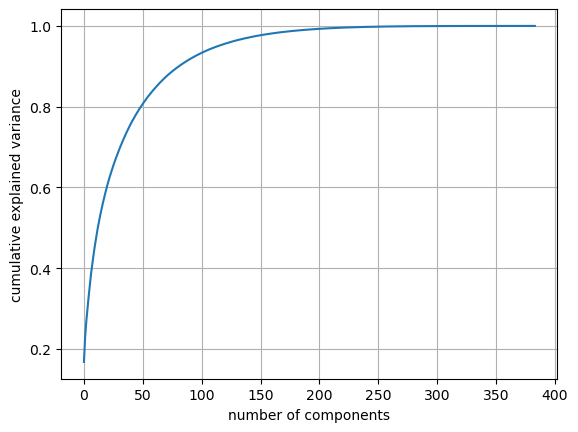

In [11]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(embeddings_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

In [12]:
# Dimentionality reduction with PCA

pca = PCA(n_components=50)
pca.fit(embeddings_scaled)
pca_embeddings_scaled = pca.transform(embeddings_scaled)
pca_embeddings_scaled.shape

(10411, 50)

## Clustering

Silhouette Score for k=2: 0.19300781
Silhouette Score for k=3: 0.16664477
Silhouette Score for k=4: 0.1835624
Silhouette Score for k=5: 0.15773344
Silhouette Score for k=6: 0.13825238
Silhouette Score for k=7: 0.15246312
Silhouette Score for k=8: 0.15842837
Silhouette Score for k=9: 0.15584315
Silhouette Score for k=10: 0.16740568
Silhouette Score for k=11: 0.1673264
Silhouette Score for k=12: 0.17032358
Silhouette Score for k=13: 0.18559885
Silhouette Score for k=14: 0.17368214
Silhouette Score for k=15: 0.19262418
Silhouette Score for k=16: 0.19601099
Silhouette Score for k=17: 0.20467332
Silhouette Score for k=18: 0.19780746
Silhouette Score for k=19: 0.21081464
Silhouette Score for k=20: 0.21448725
Silhouette Score for k=21: 0.22112136
Silhouette Score for k=22: 0.19811866
Silhouette Score for k=23: 0.20935732
Silhouette Score for k=24: 0.20822006
Silhouette Score for k=25: 0.20103127
Silhouette Score for k=26: 0.20828195
Silhouette Score for k=27: 0.2144259
Silhouette Score for k=

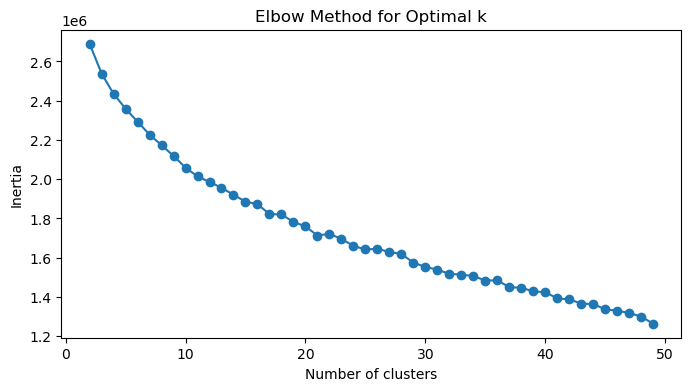

In [14]:
# plot the inertia on an elbow plot to get the optimal k

inertia = []
k_range = range(2, 50)
for i, k in enumerate(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_embeddings_scaled)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    silhouette_coeff = silhouette_score(pca_embeddings_scaled, cluster_labels)
    print(f"Silhouette Score for k={i+2}:", silhouette_coeff)


plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [24]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(pca_embeddings_scaled)
print("Cluster centers:\n", kmeans.cluster_centers_.shape)

df_k = pd.DataFrame()
cluster_labels = kmeans.labels_
df_k["labels"] = df.labels
df_k["categories"] = kmeans.labels_
df_clustered = df_k.groupby("categories")
silhouette_coeff = silhouette_score(pca_embeddings_scaled, cluster_labels)
print(f"Silhouette Score for k={optimal_k}:", silhouette_coeff)
# counts = df_clustered["tags"].value_counts()
# print(counts)

Cluster centers:
 (4, 50)
Silhouette Score for k=4: 0.1835624


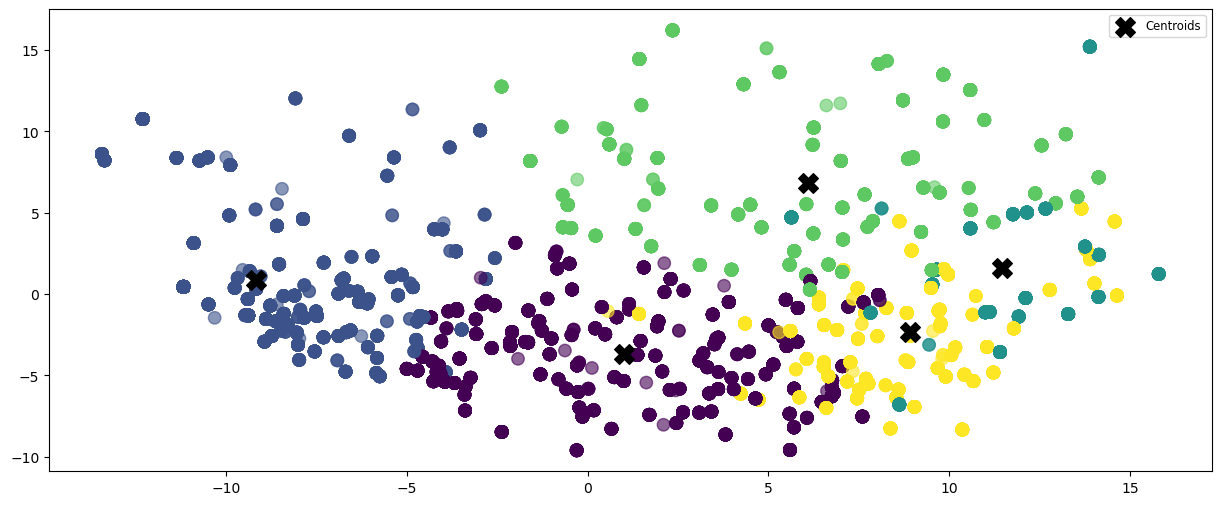

In [23]:
centroids = kmeans.cluster_centers_
plt.figure(figsize=(15, 6))

plt.scatter(pca_embeddings_scaled[:,0], pca_embeddings_scaled[:,1], c=kmeans.labels_, cmap='viridis', s=80, alpha=0.6)
plt.scatter(centroids[:,0], centroids[:,1], s=200, c='black', marker="X", label='Centroids', alpha=1)
plt.legend(fontsize='small')
plt.show()


In [29]:

pd.set_option('display.max_colwidth', None)
for cluster, group_data in df_clustered:
  print(f"Cluster: {cluster}")
  num_rows = len(group_data)
  print(f"Number of rows: {num_rows}")
  print("-" * 40)
  print("-" * 40)
  print(group_data[group_data['categories'] == 0]['labels'].unique())
  print("-" * 40)
  print("-" * 40)
  print(group_data[group_data['categories'] == 1]['labels'].unique())
  print("-" * 40)
  print("-" * 40)
  print(group_data[group_data['categories'] == 2]['labels'].unique())
  print("-" * 40)
  print("-" * 40)
  print(group_data[group_data['categories'] == 3]['labels'].unique())
  

Cluster: 0
Number of rows: 4301
----------------------------------------
----------------------------------------
['bug, discussion, documentation, duplicate, enhancement, good first issue, help wanted, invalid, question, wontfix'
 'bug, dependencies, documentation, duplicate, enhancement, good first issue, help wanted, invalid, question, wontfix'
 'bug, documentation, duplicate, enhancement, good first issue, help wanted, in-progress, invalid, npu, pending, solved, wontfix'
 'bug, documentation, duplicate, enhancement, good first issue, help wanted, invalid, low priority, question, seen and will respond later, wontfix'
 'bug, documentation, duplicate, enhancement, feature, good first issue, help wanted, installation, invalid, need more info, priority: high, priority: low, priority: medium, question, wontfix'
 'bug, external, feature, help wanted, no repro, question'
 'bug, documentation, duplicate, enhancement, good first issue, help wanted, invalid, question, server, wontfix'
 'bug, 

It seems that the separation was based mainly on the language (latin vs chinese characters).
And considering separating different languages into separate groups and applying clustinring on each group can become complex, I will use the `transformer` model from Hugging Face to classify description based on predifined categories.

In [215]:
from transformers import pipeline # pip install transformers

# NLP - Natural Language Processing
# NLG - Natural Language Generation
# MT - Machine Translation
# ML - Machine Learning
# MML - Multi-Modal Learning
# RL - Reinforcement Learning
# ASR - Automatic Speech Recognition
# TTS - Text-to-Speech
# RPA - Robotic Process Automation
# IR - Information Retrieval
# DL - Deep Learning
# OCR - Optical Character Recognition

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
candidate_categories = ["course", "tutorial", "application", "framework", "database", "library", "game", "social media", "model", "other"]
candidate_tech_type = ["NLP", "NLG", "MT", "ML", "MML", "LLM", "RL", "ASR", "TTS", "RPA", "IR", "DL", "OCR"]
unique_descriptions = df.drop_duplicates(subset=['repo_name', 'description']).reset_index(drop=True)

unique_descriptions['category'] = unique_descriptions['description'].apply(
    lambda desc: classifier(desc, candidate_categories)['labels'][0]
)
unique_descriptions['tech_type'] = unique_descriptions['description'].apply(
    lambda desc: classifier(desc, candidate_tech_type)['labels'][0]
)

df = pd.merge(df, unique_descriptions[['repo_name', 'description', 'category', 'tech_type']], 
            on=['repo_name', 'description'], how='left')

df.to_csv('./data/github_data_categorized.csv', index=False)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [216]:
df.head(50)

,org_name,repo_name,creation_date,update_date,description,repo_url,num_stars,num_forks,num_open_issues,num_pull_requests,release_tag,release_date,category
0,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.17.0,2024-07-11 16:28:57+00:00,framework
1,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.17.0-rc1,2024-07-02 04:17:28+00:00,framework
2,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.16.2,2024-06-28 18:56:30+00:00,framework
3,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.17.0-rc0,2024-06-18 20:41:46+00:00,framework
4,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.15.1,2024-03-08 19:09:29+00:00,framework
5,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.16.1,2024-03-07 18:54:30+00:00,framework
6,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.16.0-rc0,2024-02-26 22:54:41+00:00,framework
7,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.15.0,2023-11-14 18:46:08+00:00,framework
8,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.14.1,2023-11-14 18:42:20+00:00,framework
9,tensorflow,tensorflow,2015-11-07 01:19:20+00:00,2024-09-02 18:51:51+00:00,An Open Source Machine Learning Framework for Everyone,https://github.com/tensorflow/tensorflow,185285,74149,4523,34578,v2.15.0-rc1,2023-11-03 18:09:42+00:00,framework
